In [1]:
from skmultiflow.trees import HoeffdingTree, HoeffdingTreeClassifier
import random
import matplotlib
import matplotlib.pyplot as plt
from numpy import array
import numpy as np
import pandas as pd

In [ ]:
# undersample the majority class only
# use every data point of the minority class

# 1. Accumulate N data points from the majority class in the reservoir
# 2. countMinority =0 -> start training with the minority class
# 3. When the ith>=N+1 data point arrives 
# verify if it is from the minority class
# 4. If Yes, and i< 2*N => use it for training
# 5. If No, use reservoir sampling
# 6. Did we train the model with N points from the minority class
# 7. If Yes then use the reservoir 
# to train the model with N samples from the majority class as well
# 8. empty the reservoir -> go to step1

# we apply test then train method 
# i.e we dont split to train and test set
# we use every data sample to test the model and then to train it
# calculate the prequential error

# data preparation
df=pd.read_csv("iot_telemetry_data.csv")
df["light"]=df["light"].astype(int)
df["motion"]=df["motion"].astype(int)
select_cols = ['co', 'humidity', 'lpg', 'motion','smoke','temp', 'light']
data = df[select_cols].to_numpy()

#initialization of variables
N=100 # the number of data points in the reservoir
reservoir =[]
numberCorrectPredictions=0
numberSamplesTotal =0
numberTrainingSamplesTotal =0
numberTP=0    #true positives
numberFP=0    #false positives
numberFN=0    #false negatives
numberTN=0    #true negatives
result_scores=[]
result_f_scores=[]
majorityClass =0
minorityClass =1
countMajority=0
countMinority=0

#initialization of the model
#hyperparameter tuning
grace_period=10           # default 200
split_criterion ='gini'   # 'info-gain'
split_confidence = 0.001  # default 1e-07
leaf_prediction = 'mc'    # mc = majority class, default 'nba'
binary_split = False
ht = HoeffdingTreeClassifier(
            grace_period=grace_period, 
            split_criterion=split_criterion, 
            split_confidence = split_confidence,
            leaf_prediction = leaf_prediction,
            binary_split = binary_split
)

for i in range(len(data)):
    
    # take the class label value
    class_label = data[i][-1]  
    
    # take the current data point
    X=data[i][:-1]
    # X should be numpy array with shape (n_samples=1, n_features)
    X=np.array([X])
        
    if (ht.get_model_measurements['Tree size (leaves)']>=5):
        
        # start predicting
        numberSamplesTotal +=1
        
        # test then train method - we use all the samples to test 
        y_predict = ht.predict(X)

        # calculate the prequential accuracy and f-score
        print("numberCorrectPredictions****************")
        print(y_predict[0])
        print(class_label)
        if (y_predict[0] == class_label):
            numberCorrectPredictions+=1
        if (y_predict[0]==1 and class_label==1):
            numberTP+=1
        if (y_predict[0]==1 and class_label==0):
            numberFP+=1
        if (y_predict[0]==0 and class_label==1):
            numberFN+=1
        if (y_predict[0]==0 and class_label==0):
            numberTN+=1

        current_score = numberCorrectPredictions/ numberSamplesTotal
        result_scores.append(current_score)
            
        if (((numberTP + numberFP)==0) or ((numberTP + numberFN)==0)):
            current_f_score=0
        else:
            current_f_score = numberTP/(numberTP + 0.5*(numberFP+numberFN))
         
        result_f_scores.append(current_f_score)
    else:
        current_f_score=0
        result_scores.append(0)
        result_f_scores.append(current_f_score)
    
    # print prequential confusion matrix
    if (numberSamplesTotal % 1000 ==0):
        print(f"TotalClassified:{numberSamplesTotal} CorrectPredictions:{numberCorrectPredictions} TP:{numberTP} FP:{numberFP} FN:{numberFN} TN:{numberFN}  F-score:{current_f_score}")
        
    # now train the model
    if (class_label==majorityClass):
        countMajority+=1
        if (len(reservoir) <= N-1):
            # accumulate N elements in the reservoir
            reservoir.append(data[i])
        else:
            m=random.randint(0, i)
            if (m<N):
                reservoir[m]=data[i]          
    else:
        # we need to have N data points in the reservoir before proceeding
        if (len(reservoir) == N) : 
            # test and train the Hoeffding tree with the current data point
            countMinority+=1
 
            #train the Hoeffding Tree with the current sample (minority)   
            ht=ht.partial_fit(X = X,y=np.array([class_label]))
            numberTrainingSamplesTotal +=1
                 
        
        # did we train with N points from the minority class?
        # if Yes we need to train with N points from the reservoir
        # and we will empty the reservoir 
        if (countMinority ==N):
            
            # train the Hoeffding tree with the N samples from the reservoir (N from majority class)      
            for r in reservoir:
                
                # train the Hoeffding Tree with the sample     
                ht=ht.partial_fit(X = np.array([r[:-1]]),y=np.array([r[-1]]))
                numberTrainingSamplesTotal +=1

                
            # clear the reservoir after training
            reservoir=[]
            countMajority=0
            countMinority =0 
            
print(ht.get_model_measurements)

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 CorrectPredictions:0 TP:0 FP:0 FN:0 TN:0  F-score:0
TotalClassified:0 Co

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
TotalClassified:5000 CorrectPredictions:4995 TP:1320 FP:4 FN:1 TN:1  F-score:0.998109640831758
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCo

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
TotalClassified:9000 CorrectPredictions:8990 TP:2257 FP:4 FN:6 TN:6  F-score:0.997789566755084
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrec

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
TotalClassified:15000 CorrectPredictions:14987 TP:3693 FP:4 FN:9 TN:9  F-score:0.9982430058115962
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
TotalClassified:18000 CorrectPredictions:17983 TP:4440 FP:4 FN:13 TN:13  F-score:0.9980892435652468
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
n

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrect

numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrect

numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
TotalClassified:23000 CorrectPredictions:22047 TP:6115 FP:353 FN:600 TN:600  F-score:0.9277099294546006
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
num

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberC

1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberC

0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberC

numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCor

numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
TotalClassified:87000 CorrectPredictions:83584 TP:23223 FP:1

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
TotalClassified:93000 CorrectPredictions:89385 TP:24870 FP:1690 FN:1925 TN:1925  F-score:0.9322462749508013
numberCorrectPredictions****************
1
1.0

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
1.0
numberCorrect

0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
TotalClassified:106000 CorrectPredictions:101499 TP:27961 FP

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberC

1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberC

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCor

0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCor

numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrect

numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrect

0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberC

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrect

numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
TotalClassified:113000 CorrectPredictions:108417 TP:29765 FP:2355 FN:2228 TN:2228  F-score:0.9285168374588617
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
1
1.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0.0
numberCorrectPredictions****************
0
0

Text(0.5, 1.0, 'Accuracy and F-Score for Hoeffding Tree')

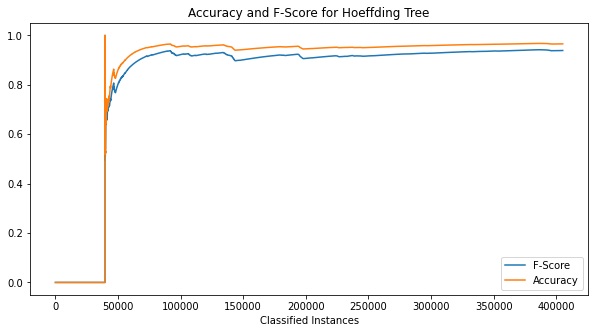

In [9]:
plt.figure(figsize=(10,5))
plt.plot(result_f_scores, label="F-Score")
plt.plot(result_scores, label="Accuracy")
plt.legend()
plt.xlabel("Classified Instances")
plt.title("Accuracy and F-Score for Hoeffding Tree")

Text(0.5, 1.0, 'Accuracy and F-Score for Hoeffding Tree')

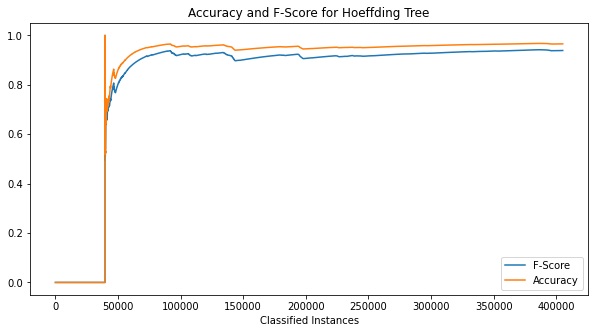

In [7]:
plt.figure(figsize=(10,5))
plt.plot(result_f_scores, label="F-Score")
plt.plot(result_scores, label="Accuracy")
plt.legend()
plt.xlabel("Classified Instances")
plt.title("Accuracy and F-Score for Hoeffding Tree")

Text(0.5, 0, 'Number Training Samples')

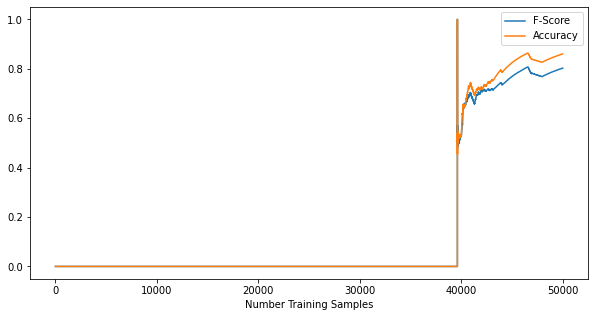

In [8]:
# take only the the first few results
plt.figure(figsize=(10,5))
plt.plot(result_f_scores[:50000], label="F-Score")
plt.plot(result_scores[:50000], label="Accuracy")
plt.legend()
plt.xlabel("Number Training Samples")